In [1]:
from definitions import *
from trainTestValSplit import getTrainTestValSplit
from preProcessing import preProcess

from sklearn.metrics import f1_score

In [2]:
train_concat, test_concat, val_concat = getTrainTestValSplit(
    _dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/Processed'
)

In [3]:
train_x, train_y = preProcess(train_concat)
test_x, test_y = preProcess(test_concat)
val_x, val_y = preProcess(val_concat)

columns = train_x.columns
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)
val_x = val_x.fillna(0)

n_columns = len(columns)
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()

In [4]:
n_features: int = n_columns

In [5]:
train_y = encodeTarget(train_y)
test_y = encodeTarget(test_y)
val_y = encodeTarget(val_y)

In [6]:
train_x = reshape_and_truncate(train_x, (-1, window_size, n_features))
train_y = reshape_and_truncate(train_y, (-1, window_size, len(main_activity_label_classes)))

test_x = reshape_and_truncate(test_x, (-1, window_size, n_features))
test_y = reshape_and_truncate(test_y, (-1, window_size, len(main_activity_label_classes)))

val_x = reshape_and_truncate(val_x, (-1, window_size, n_features))
val_y = reshape_and_truncate(val_y, (-1, window_size, len(main_activity_label_classes)))

In [7]:
with tf.device('/cpu:0'):
    model = tf.keras.Sequential()

    layer = tf.keras.layers.Normalization(axis=-1)
    layer.adapt(train_x)
    model.add(layer)
    model.add(tf.keras.layers.LSTM(100, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_y, activation=tf.keras.activations.softmax))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=
    tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
    ), metrics=['acc'])
    history = model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size,
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience,
                                                             mode='auto', restore_best_weights=True)])
    predict = model.predict(test_x)

Epoch 1/100
663/663 [==============================] - 11s 13ms/step - loss: 0.8787 - acc: 0.7186 - val_loss: 0.6681 - val_acc: 0.7748
Epoch 2/100
663/663 [==============================] - 9s 13ms/step - loss: 0.5721 - acc: 0.8065 - val_loss: 0.6186 - val_acc: 0.7764
Epoch 3/100
663/663 [==============================] - 9s 13ms/step - loss: 0.4779 - acc: 0.8347 - val_loss: 0.6400 - val_acc: 0.7688
Epoch 4/100
663/663 [==============================] - 9s 13ms/step - loss: 0.4254 - acc: 0.8510 - val_loss: 0.6438 - val_acc: 0.7741
Epoch 5/100
663/663 [==============================] - 9s 13ms/step - loss: 0.3836 - acc: 0.8655 - val_loss: 0.6745 - val_acc: 0.7720
Epoch 6/100
663/663 [==============================] - 9s 13ms/step - loss: 0.3534 - acc: 0.8758 - val_loss: 0.6751 - val_acc: 0.7730
Epoch 7/100
208/208 [==============================] - 2s 4ms/step


In [8]:
gold_labels = get_labels(test_y)
predicted_labels = get_labels(predict)

In [9]:
f1_score(gold_labels, predicted_labels, average='weighted')

0.7753156931329516

In [10]:
tf.math.confusion_matrix(gold_labels, predicted_labels)

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[1335,    6,   49,    5,    7,    0,    2],
       [   6, 1652,  269,   30,    1,    0,    2],
       [  21,   98, 1972,  125,   21,    0,    3],
       [  19,   76,  402,  160,   27,    1,    4],
       [   6,    2,   64,   27,   66,    1,    2],
       [   3,    8,    1,    1,    3,    0,    0],
       [  35,    1,   35,   14,   20,    1,   67]])>

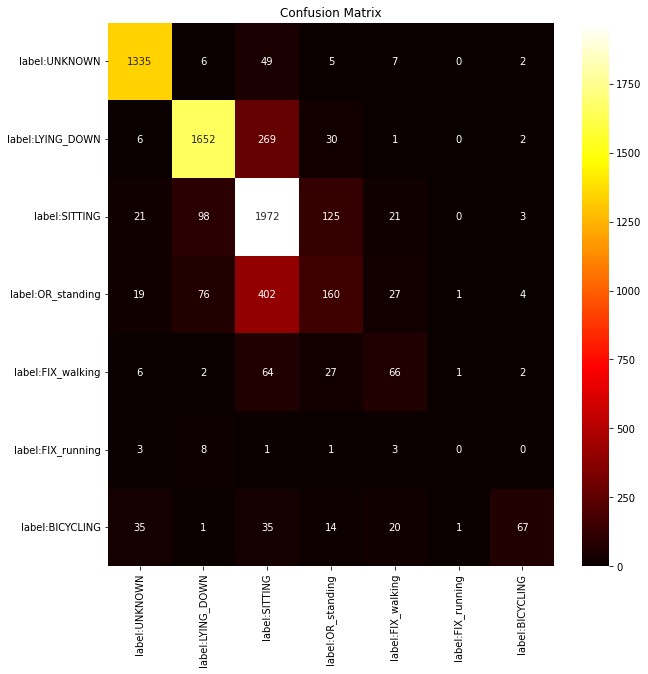

In [11]:
plot_conf_matrix(gold_labels, predicted_labels)

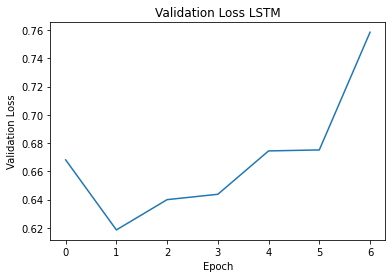

In [12]:
plot_val_loss_progress(history)